In [5]:
import mixsea as mx
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pandas as pd

# data handling
import scipy.io as sio
import datetime

# import my self written functions
from location import Location
from ctd_cast import CTDCast
import helper_functions as helper


In [17]:
# Set up conversion from ID number to cast name    
def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate

from scipy.stats import binned_statistic
def bin_to_10m_resolution(x, values, bin_center):
    bin_edges = list(bin_center - np.mean(np.diff(bin_center))/2)
    bin_edges.append(bin_center[-1] + np.mean(np.diff(bin_center))/2)
    bin_means = binned_statistic(x = x, values = values, bins= bin_edges, statistic = "mean")[0]
    return bin_means         
        
def get_PS129_data():
    
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create as many CTDCast objects as casts itself
    list_of_LADCP_casts= [CTDCast() for _ in ladcp_cast_numbers]

    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_LADCP_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name  

    # iterate over LADCP data
    for path, cast in zip(ladcp_paths,list_of_LADCP_casts):
        #print(sio.whosmat(path))
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        cast["u"] = np.squeeze(data["u"]).astype("double")
        cast["v"] = np.squeeze(data["v"]).astype("double")
        cast["depth"] = np.squeeze(data["z"]).astype("double")
        spacing = np.mean(np.diff(cast["depth"]))
        cast["uz"] = np.gradient(cast["u"],spacing)
        cast["vz"] = np.gradient(cast["v"],spacing)
        
        cast.location = Location(lat = lat, lon = lon)
        cast.date = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
            

    #create as many CTDCast objects as casts itself
    list_of_CTD_casts= [CTDCast() for _ in ladcp_cast_numbers]
                               
    # iterate over CTD data
    for LADCP_cast, CTD_cast in zip(list_of_LADCP_casts, list_of_CTD_casts):
        CTD_cast.name = LADCP_cast.name
        CTD_cast.location = LADCP_cast.location
        CTD_cast.date = LADCP_cast.date
        
        #load CTD data to that LADCP Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{LADCP_cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 323, usecols = (0,1,5), unpack = True)
            CTD_depth = -1 * gsw.z_from_p(p = pressure, lat = LADCP_cast.location.lat)
        
            LADCP_cast["t"] = bin_to_10m_resolution(
                x = CTD_depth, 
                values = in_situ_temperature, 
                bin_center = LADCP_cast["depth"].to_list(),
            )
                             
            LADCP_cast["SP"] = bin_to_10m_resolution(
                x = CTD_depth, 
                values = practical_salinity, 
                bin_center = LADCP_cast["depth"].to_list(),
            )
             
            CTD_cast["depth"] = CTD_depth                       
            CTD_cast["t"] = in_situ_temperature  
            CTD_cast["SP"] = practical_salinity
                                 
                                   

        except ValueError as e:
            raise e
            print(f"Not able to load profile PS129_{LADCP_cast.name} at {LADCP_cast.location}")
            continue
        #print(cast.name)     

    return [list_of_LADCP_casts, list_of_CTD_casts]


In [18]:
list_of_LADCP_casts, list_of_CTD_casts = get_PS129_data()
# remove all casts further east than 45° W 
list_of_LADCP_casts[:] = [cast for cast in list_of_LADCP_casts if cast.location.lon < -45]
list_of_CTD_casts[:] = [cast for cast in list_of_CTD_casts if cast.location.lon < -45]

# check order
for LADCP_cast, CTD_cast in zip(list_of_LADCP_casts, list_of_CTD_casts):
    if LADCP_cast.name != CTD_cast.name:
        print("Wrong order")

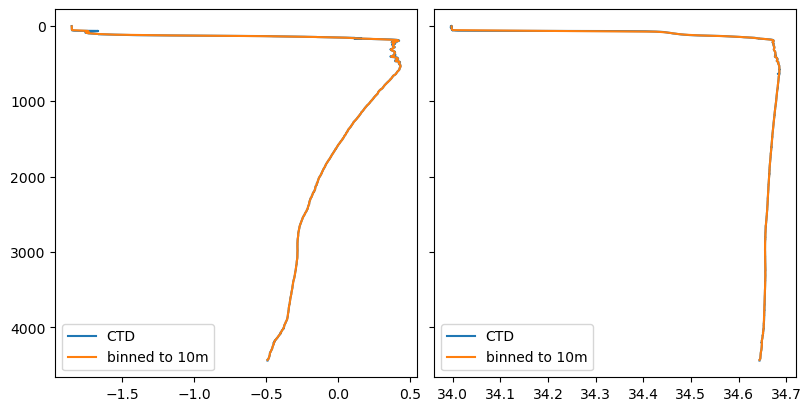

In [20]:
#check accuracy of binning
cast = list_of_LADCP_casts[0]  
path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{cast.name}.cnv"
pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 323, usecols = (0,1,5), unpack = True)
CTD_depth = -1 * gsw.z_from_p(p = pressure, lat = cast.location.lat)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True, sharey=True
)
ax[0].plot(in_situ_temperature, CTD_depth, label = "CTD")
ax[0].plot(cast["t"], cast["depth"], label = "binned to 10m")
ax[1].plot(practical_salinity, CTD_depth, label = "CTD")
ax[1].plot(cast["SP"], cast["depth"], label = "binned to 10m")
            
ax[0].legend()
ax[1].legend()
ax[0].invert_yaxis()            

In [25]:
ctd["lon"] = ctd.location.lon
ctd["lat"] = ctd.location.lat
ctd.to_csv("./WS_ctd.csv")
ctd

,depth,t,SP,lon,lat
0,5.941326,-1.8495,33.9978,-45.304,-64.48
1,6.931530,-1.8494,33.9980,-45.304,-64.48
2,7.921730,-1.8494,33.9960,-45.304,-64.48
3,8.911924,-1.8491,33.9977,-45.304,-64.48
4,9.902114,-1.8488,33.9978,-45.304,-64.48
...,...,...,...,...,...
4520,4434.769482,-0.4897,34.6440,-45.304,-64.48
4521,4435.739404,-0.4893,34.6440,-45.304,-64.48
4522,4436.709321,-0.4894,34.6440,-45.304,-64.48
4523,4437.679235,-0.4895,34.6439,-45.304,-64.48


In [24]:
ladcp.to_csv("./WS_ladcp.csv")
ladcp

,u,v,depth,uz,vz,t,SP
0,0.025878,-0.063532,10.0,-7.463474e-15,1.209033e-14,-1.848980,33.997650
1,0.025878,-0.063532,20.0,4.639485e-04,-1.058650e-03,-1.848850,33.997740
2,0.035157,-0.084705,30.0,6.386727e-04,-1.337190e-03,-1.848570,33.997920
3,0.038652,-0.090276,40.0,8.566458e-05,9.679979e-05,-1.848410,33.997900
4,0.036871,-0.082769,50.0,-8.848681e-04,9.770607e-04,-1.848240,33.998220
...,...,...,...,...,...,...,...
438,-0.004807,0.014616,4390.0,-2.395774e-04,-7.561731e-05,-0.477636,34.645991
439,-0.007628,0.017270,4400.0,-5.761458e-04,1.019111e-03,-0.479750,34.645860
440,-0.016330,0.034998,4410.0,-1.271107e-03,1.926388e-03,-0.481140,34.645770
441,-0.033050,0.055797,4420.0,-1.804178e-03,1.620757e-03,-0.484010,34.645290


# Actual start for Shear/Strain Calculations

Our example data contain some NaN values, as is common with observational datasets. Below we isolate the good data by removing NaNs. See the section [Missing Data](#Missing-Data) for using `nan_shearstrain` with input data that contains NaNs.

In [21]:
#ctd = mx.helpers.read_ctd_testfile()
#ladcp = mx.helpers.read_ladcp_testfile()

def nonan(data):
    notnan = [np.isfinite(v) for k, v in data.items()]
    notnan = np.vstack(notnan)
    notnan = np.all(notnan, axis=0)
    return notnan

index = 0
ctd = list_of_CTD_casts[index]
ladcp = list_of_LADCP_casts[index]

notnan = nonan(ctd)
depth = ctd["depth"][notnan]
t = ctd["t"][notnan]
SP = ctd["SP"][notnan]
lon = ctd.location.lon
lat = ctd.location.lat

notnan = nonan(ladcp)
u = ladcp["u"][notnan]
v = ladcp["v"][notnan]
uz = ladcp["uz"][notnan]
vz = ladcp["vz"][notnan]
depth_sh = ladcp["depth"][notnan]

In [ ]:
for cast in list_of_LADCP_casts:
    print(len(cast))

A quick overview plot of the data:

In [ ]:
for LADCP_cast, CTD_cast in zip(list_of_LADCP_casts, list_of_CTD_casts):
    plt.plot(LADCP_cast.location.lon,max(LADCP_cast["depth_sh"]),"r.")
    plt.plot(CTD_cast.location.lon,max(CTD_cast["depth"]),"k.")
plt.gca().invert_yaxis() 
plt.gca().set_ylabel("Depth") 
plt.gca().set_xlabel("Longitude")

In [ ]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(9, 6), constrained_layout=True, sharey=True
)
ax[0].plot(t, depth)
ax[0].set(ylabel="depth [m]", xlabel="temperature [°C]")
ax[1].plot(SP, depth)
ax[1].set(xlabel="Practical Salinity")
ax[2].plot(u, depth_sh, label="u")
ax[2].plot(v, depth_sh, label="v")
ax[2].set(xlabel="velocity [m/s]")
ax[2].legend()

ax[3].plot(uz, depth_sh, label=r"u$_{z}$")
ax[3].plot(vz, depth_sh, label=r"v$_{z}$")

ax[3].set(xlabel="shear [1/s]")
ax[3].legend()
ax[0].invert_yaxis()